In [5]:
import os
import yaml

config = yaml.safe_load(open("configs.yml"))
os.environ["TAVILY_API_KEY"] = config["TAVILY_API_KEY"]
os.environ["LANGCHAIN_API_KEY"] = config["LANGCHAIN_API_KEY"]
os.environ["LANGCHAIN_TRACING_V2"] = str(config["LANGCHAIN_TRACING_V2"]).lower()
os.environ["LANGCHAIN_ENDPOINT"] = config["LANGCHAIN_ENDPOINT"]
os.environ["GROQ_API_KEY"]=config["GROQ_API_KEY"]

In [6]:
os.environ["LANGCHAIN_PROJECT"] ='llama3-tool-use-agent'


Tool USE

In [7]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_community.tools.tavily_search import TavilySearchResults

@tool
def magic_function(input:int) -> int:
    """Applies a magic functionn to an input"""
    return input+2

@tool
def web_search(input:str) ->str:
    """Runs web search"""
    web_search_tool=TavilySearchResults()
    docs=web_search_tool.invoke({"query":input})
    return docs

tools=[magic_function,web_search]


In [8]:
magic_function

StructuredTool(name='magic_function', description='Applies a magic functionn to an input', args_schema=<class 'pydantic.v1.main.magic_functionSchema'>, func=<function magic_function at 0x00000285E93058A0>)

In [9]:
from datetime import datetime
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant for with two tools: (1) web search, "
            "(2) a custom, magic_function, Use web search for current event and use "
            "magic_function if the question directly asks for it. Otherwise, answer directly"
            "Current time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

# LLM chain
llm = ChatGroq(temperature=0, model="llama3-70b-8192")
assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)

In [10]:
question='What is magic_funtion(3)'
payload=assistant_runnable.invoke({"messages":[("user",question)]})
payload.tool_calls


[{'name': 'magic_function', 'args': {'input': 3}, 'id': 'call_ec3e'}]

In [11]:
question='What is the capital of the US'
payload=assistant_runnable.invoke({"messages":[("user",question)]})
payload.tool_calls


[]

Memory

In [12]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Planning

In [13]:
from datetime import datetime
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig

# Assistant
class Assistant:
    
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            # If it is a tool call -> response is valid
            # If it has meaninful text -> response is valid
            # Otherwise, we re-prompt it b/c response is not meaninful
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

In [14]:
def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print(f"Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


Graph

In [15]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.runnables import RunnableLambda

# Graph
builder = StateGraph(State)

# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))

# Define edges: these determine how the control flow moves
builder.set_entry_point("assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition, 
    # "tools" calls one of our tools. END causes the graph to terminate (and respond to the user)
    {"tools": "tools", END: END},
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
memory = SqliteSaver.from_conn_string(":memory:")
graph = builder.compile(checkpointer=memory)

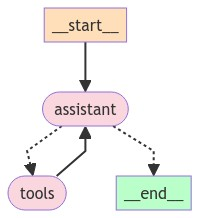

In [16]:
from IPython.display import Image,display
try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [17]:
questions=["What is magic_function(3)","What is the weather in SF now?"]

import uuid
_printed=set()
thread_id=str(uuid.uuid4())

config={
    "configurable":{
        "thread_id":thread_id, 
    }
}

events=graph.stream({"messages":questions[0]},config,stream_mode="values")
for event in events:
    _print_event(event,_printed)

================================ Human Message =================================

What is magic_function(3)
================================== Ai Message ==================================
Tool Calls:
  magic_function (call_jcqb)
 Call ID: call_jcqb
  Args:
    input: 3
================================= Tool Message =================================
Name: magic_function

5
================================== Ai Message ==================================

The result of the magic_function is 5.


In [18]:
questions=["What is magic_function(3)","What is the weather in SF now?"]

import uuid
_printed=set()
thread_id=str(uuid.uuid4())

config={
    "configurable":{
        "thread_id":thread_id, 
    }
}

events=graph.stream({"messages":questions[1]},config,stream_mode="values")
for event in events:
    _print_event(event,_printed)

================================ Human Message =================================

What is the weather in SF now?
================================== Ai Message ==================================
Tool Calls:
  web_search (call_esjy)
 Call ID: call_esjy
  Args:
    input: current weather in San Francisco
================================= Tool Message =================================
Name: web_search

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'San Francisco', 'region': 'California', 'country': 'United States of America', 'lat': 37.78, 'lon': -122.42, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1720857816, 'localtime': '2024-07-13 1:03'}, 'current': {}}"}, {"url": "https://forecast.weather.gov/zipcity.php?inputstring=San+Francisco,CA", "content": "San Francisco CA 37.77\u00b0N 122.41\u00b0W (Elev. 131 ft) Last Update: 1:26 pm PDT Jul 10, 2024. Forecast Valid: 5pm PDT Jul 10, 2024-6pm PDT Jul 17, 2024 . Forecast Discussion . Additional Resources. Radar